# Data load

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("data/train.csv")
df.tail(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
701775,id0924227,1,1/1/16 0:01,1/1/16 0:13,1,-73.970108,40.759800,-73.989357,40.742989,N,736
701776,id0190469,2,1/1/16 0:00,1/1/16 0:14,5,-73.981743,40.719158,-73.938828,40.829182,N,849
701777,id1665586,1,1/1/16 0:00,1/1/16 0:22,1,-73.985085,40.747166,-73.958038,40.717491,N,1294


# Classify columns [Ignore, X, Y]

In [2]:
# ignore : id, dropoff_datetime
dfY = df[['trip_duration']].astype(int)
dfX = df.iloc[:,1:-1];del dfX['dropoff_datetime']

print(dfY.loc[55])
dfX.head(3)
dfY.describe()

trip_duration    86073
Name: 55, dtype: int64


,trip_duration
count,7.017780e+05
mean,9.387318e+02
std,6.772504e+03
min,1.000000e+00
25%,3.900000e+02
50%,6.480000e+02
75%,1.047000e+03
max,3.526282e+06


# Manipulate column

## Add column

In [3]:
# Add 'distance' column
 # 위도 경도 사이의 거리 구하는 공식
  # 반지름 * arccos(sin(위도1)*sin(위도2)+cos(위도1)*cos(위도2)*cos(경도차))
   # 지구 반지름 : 6378.137km
   # 각 삼각함수 내에 들어가야 하는 파라미터 값은 radian value => degree * pi / 180 = np.radians()

p_la = np.radians(df['pickup_latitude'])
d_la = np.radians(df['dropoff_latitude'])
theta = np.radians(df['dropoff_longitude']-df['pickup_longitude'])

dfX['distance'] = 6378.137 * np.arccos(np.sin(p_la)*np.sin(d_la) + np.cos(p_la)*np.cos(d_la)*np.cos(theta))
dfX['distance'].fillna(0, inplace=True)

dfX.loc[55]

/Users/ray/.pyenv/versions/3.6.1/envs/python_dss/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


vendor_id                         2
pickup_datetime       4/30/16 23:51
passenger_count                   1
pickup_longitude           -74.0057
pickup_latitude             40.7452
dropoff_longitude          -73.9891
dropoff_latitude            40.7581
store_and_fwd_flag                N
distance                    2.00323
Name: 55, dtype: object

## Split datetime into date and time

In [4]:
# split datetime into date and time
# http://strftime.org

df_split = dfX['pickup_datetime'].str.split(' ', expand=True)
#df_date = df_split[0].str.split('/', expand=True)
df_time = df_split[1].str.split(':', expand=True)
dfX['pickup_date'] = pd.to_datetime(df_split[0], format='%m/%d/%y')
#dfX['pickup_time'] = pd.to_datetime(df_split[1], format='%H:%M').dt.time

#dfX['pickup_month'] = df_date[0].astype(int)
#dfX['pickup_date'] = df_date[1].astype(int)

dfX['pickup_hour'] = df_time[0].astype(int)
#dfX['pickup_minute'] = df_time[1].astype(int)

#del dfX['pickup_datetime']

dfX.tail(3)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance,pickup_date,pickup_hour
701775,1,1/1/16 0:01,1,-73.970108,40.759800,-73.989357,40.742989,N,2.477347,2016-01-01,0
701776,2,1/1/16 0:00,5,-73.981743,40.719158,-73.938828,40.829182,N,12.770911,2016-01-01,0
701777,1,1/1/16 0:00,1,-73.985085,40.747166,-73.958038,40.717491,N,4.014623,2016-01-01,0


#  Split dfX to CONtinuous value AND CATegorical value

## Split CONtinuous value : 10 columns

In [5]:
# 월, 일, 시, 분 은 연속 변수? 카테고리 변수? 대소판단이 가능하여 일단 연속변수에 넣었으나...
cols_con = ['passenger_count', 'pickup_date', 'pickup_hour', 'distance',\
            'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

In [6]:
dfX_con = dfX[cols_con]
print(len(dfX_con.columns))

dfX_con.loc[673074:673080], dfY.loc[673074:673080]

8


(        passenger_count pickup_date  pickup_hour    distance  \
 673074                2  2016-01-06           20    2.420003   
 673075                1  2016-01-06           20    1.015948   
 673076                1  2016-01-06           20    3.756808   
 673077                3  2016-01-06           20    2.464583   
 673078                5  2016-01-06           20  892.212471   
 673079                1  2016-01-06           20    2.380999   
 673080                1  2016-01-06           20    2.030686   
 
         pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  
 673074        -73.972328        40.762413         -73.988594         40.744503  
 673075        -73.971039        40.759315         -73.959763         40.762531  
 673076        -73.974701        40.750973         -73.947624         40.777775  
 673077        -73.956215        40.775551         -73.985031         40.779293  
 673078        -71.799896        35.081532         -79.352837       

## Split CATegorical value : 2 columns

In [7]:
cols_cat = ['vendor_id', 'store_and_fwd_flag']

In [41]:
dfX_cat = dfX[cols_cat]
print(len(dfX_cat.columns))
dfX_cat.tail(3)
dfX_cat.loc[54:57]
print(dfX['vendor_id'][3])

2
2


## DESCRIBE CONtinuous values

In [9]:
print(len(dfX_con.describe().columns))
dfX_con.describe()

7


,passenger_count,pickup_hour,distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000
mean,1.666577,13.637749,3.401137,-73.973665,40.750969,-73.973583,40.751836
std,1.319466,6.379120,4.253468,0.043910,0.033139,0.044214,0.037572
min,0.000000,0.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141
25%,1.000000,9.000000,1.222959,-73.991829,40.737400,-73.991325,40.735959
50%,1.000000,14.000000,2.075242,-73.981789,40.754150,-73.979828,40.754478
75%,2.000000,19.000000,3.827995,-73.967567,40.768246,-73.963249,40.769691
max,8.000000,23.000000,892.212471,-61.335529,43.486885,-61.335529,43.674000


# Visualize CON

In [10]:
dfY.describe()

,trip_duration
count,7.017780e+05
mean,9.387318e+02
std,6.772504e+03
min,1.000000e+00
25%,3.900000e+02
50%,6.480000e+02
75%,1.047000e+03
max,3.526282e+06


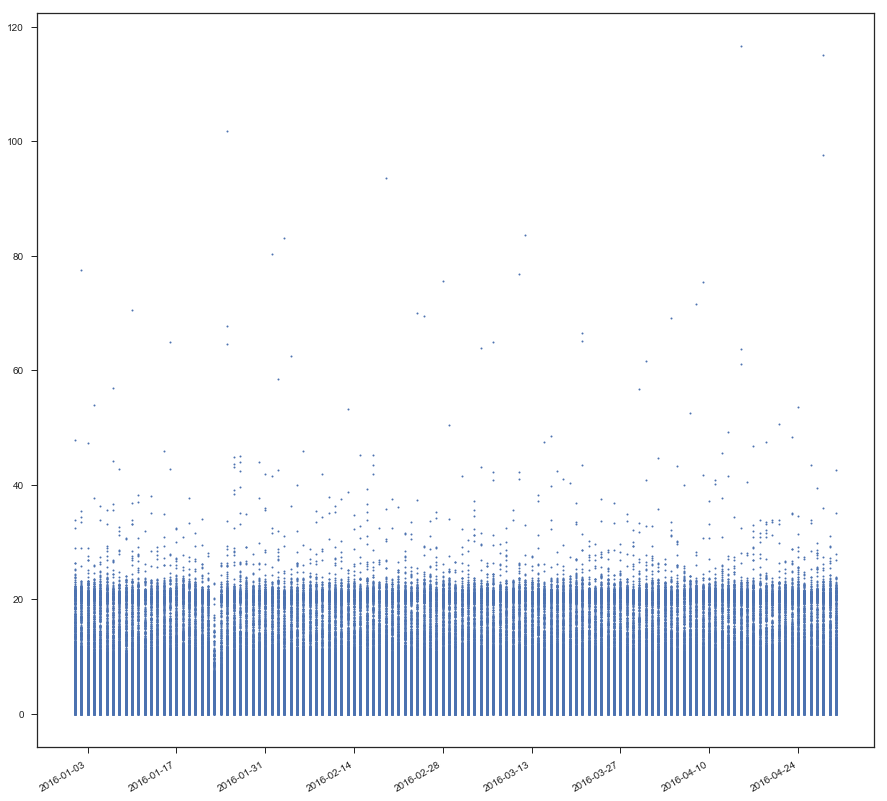

In [26]:
#날짜별 거리

fig, ax = plt.subplots(figsize=(15,15))
#ax.plot_date(dfX['pickup_date'], dfY['trip_duration'], linestyle='--')
screen = (dfY['trip_duration']<10000) & (dfX['distance'] != 0) & (dfX['distance']/dfY['trip_duration']*3600 < 200)
#ax.plot_date(dfX['pickup_date'][screen], dfX['distance'][screen], linestyle='--')
ax.plot_date(dfX['pickup_date'][screen], dfX['distance'][screen], ms=2)

fig.autofmt_xdate()

In [ ]:
#시간별 빈도
plt.figure(figsize=(15,15))
sns.countplot(dfX['pickup_hour'])

In [ ]:
#시간별 거리
fig, ax = plt.subplots(figsize=(15,15))
#ax.plot_date(dfX['pickup_date'], dfY['trip_duration'], linestyle='--')
screen = (dfY['trip_duration']<10000) & (dfX['distance'] != 0) & (dfX['distance']/dfY['trip_duration']*3600 < 200)
#ax.plot_date(dfX['pickup_date'][screen], dfX['distance'][screen], linestyle='--')
plt.scatter(dfX['pickup_hour'][screen], dfX['distance'][screen])

fig.autofmt_xdate()

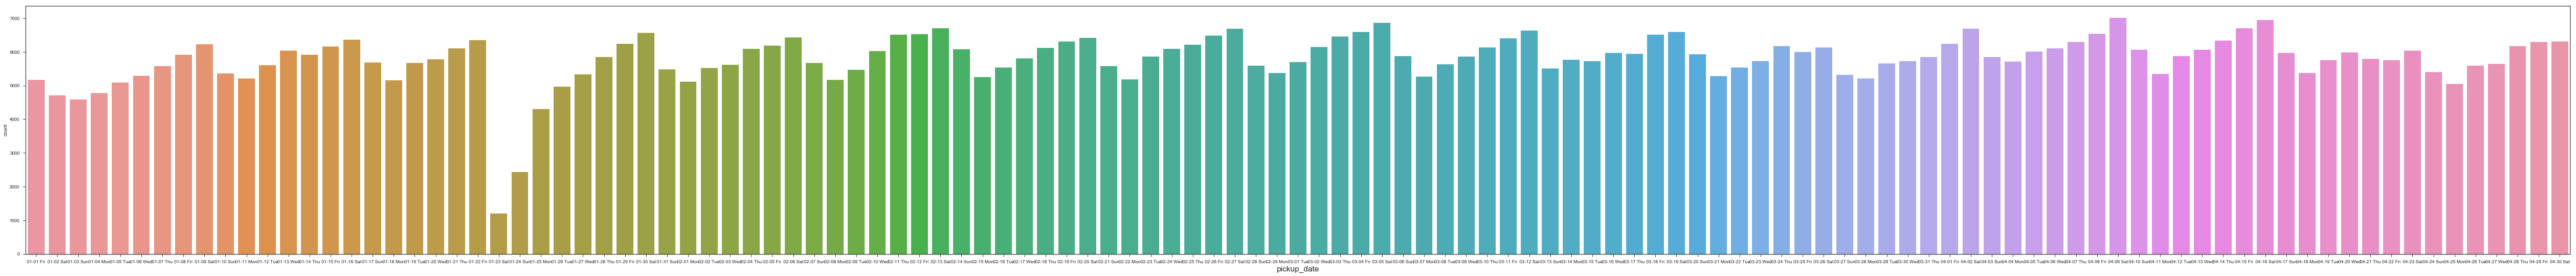

In [22]:
#날짜별 빈도
plt.figure(figsize=(100,10))
plt.xlabel('pickup_date', fontsize='xx-large')
sns.countplot(dfX['pickup_date'][::-1].dt.strftime('%m-%d %a'))

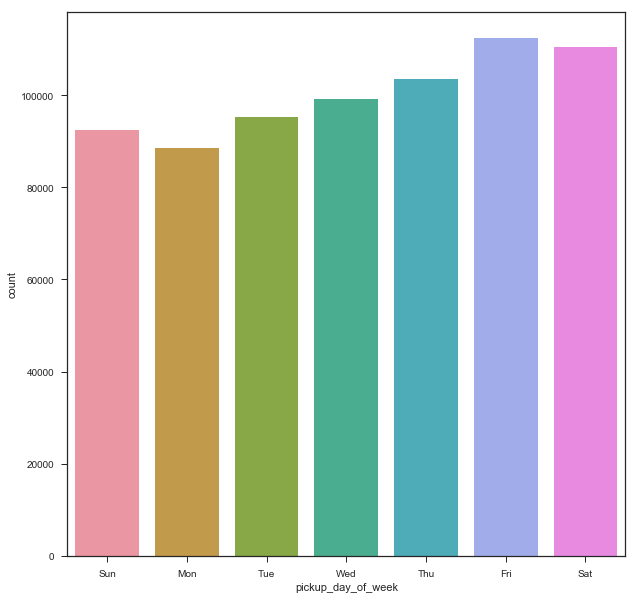

In [21]:
#요일별 빈도
plt.figure(figsize=(10,10))
sns.countplot(dfX['pickup_date'].dt.strftime('%a'), order=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.xlabel('pickup_day_of_week')

ValueError: x and y must have same first dimension, but have shapes (701778,) and (1,)

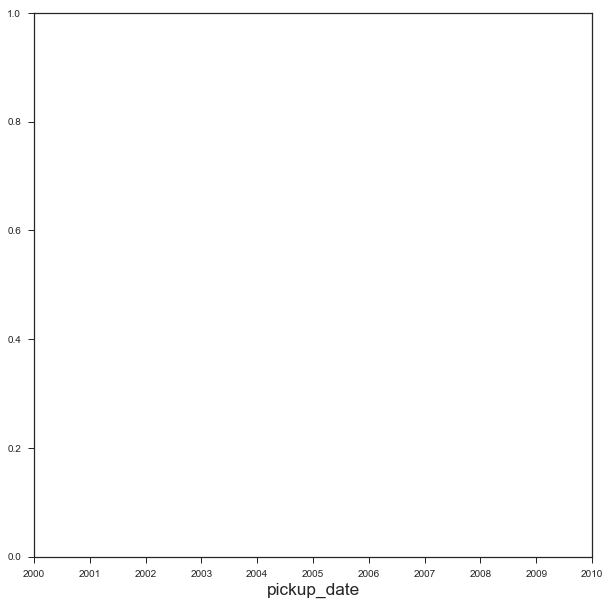

In [50]:
#요일별 vendor_id 1
plt.figure(figsize=(10,10))
df_vid = dfX[dfX['vendor_id'] == 1]
plt.xlabel('pickup_date', fontsize='xx-large')
#sns.countplot(df_vid['pickup_date'][::-1].dt.strftime('%m-%d %a'))
plt.plot_date(dfX['pickup_date'].dt.strftime('%m-%d %a'), df_vid['pickup_date'].count)

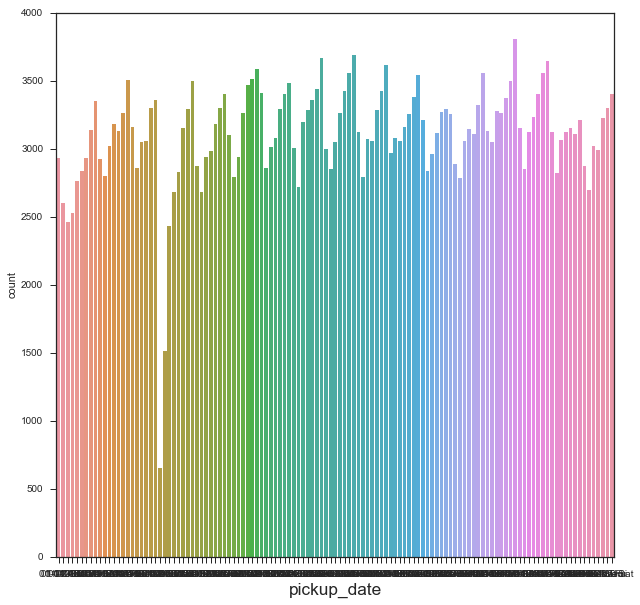

In [48]:
#요일별 vendor_id 2
plt.figure(figsize=(10,10))
df_vid = dfX[dfX['vendor_id'] == 2]
plt.xlabel('pickup_date', fontsize='xx-large')
sns.countplot(df_vid['pickup_date'][::-1].dt.strftime('%m-%d %a'))

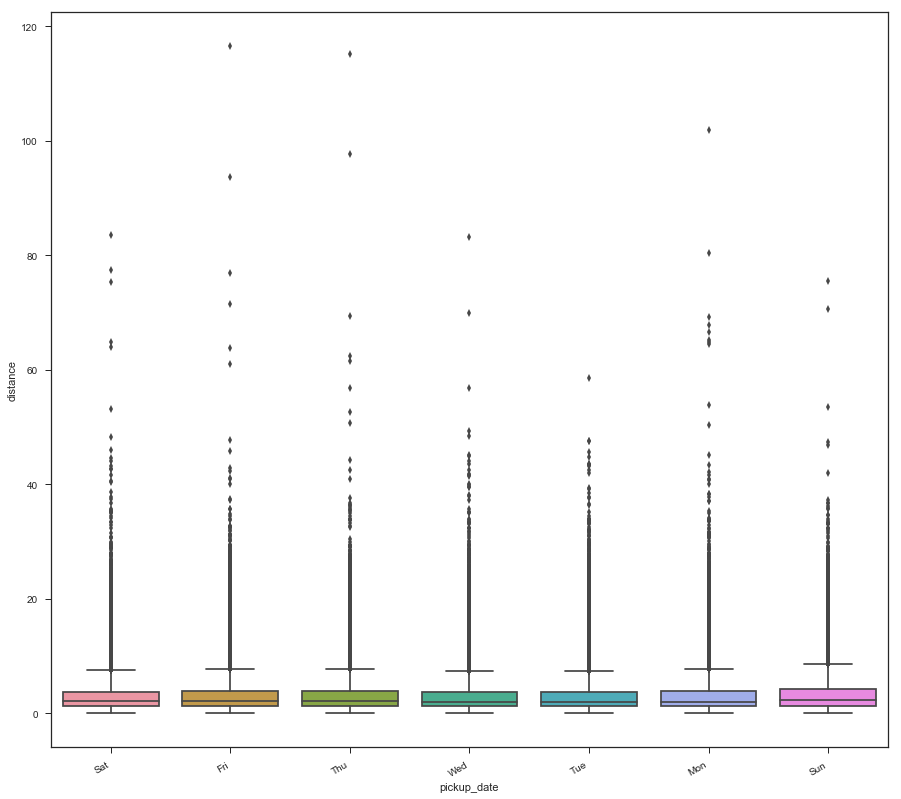

In [28]:
#요일별 거리

fig, ax = plt.subplots(figsize=(15,15))
#ax.plot_date(dfX['pickup_date'], dfY['trip_duration'], linestyle='--')
screen = (dfY['trip_duration']<10000) & (dfX['distance'] != 0) & (dfX['distance']/dfY['trip_duration']*3600 < 200)
#ax.plot_date(dfX['pickup_date'][screen], dfX['distance'][screen], linestyle='--')
sns.boxplot(dfX['pickup_date'].dt.strftime('%a'), dfX['distance'][screen])

fig.autofmt_xdate()

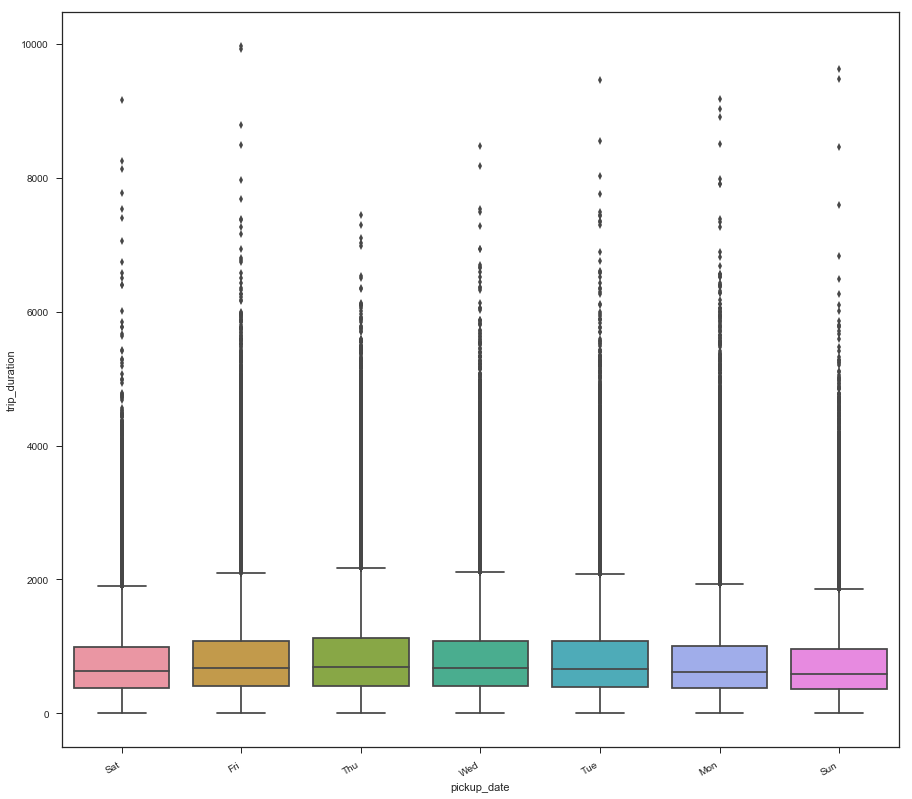

In [29]:
#요일별 시간

fig, ax = plt.subplots(figsize=(15,15))
#ax.plot_date(dfX['pickup_date'], dfY['trip_duration'], linestyle='--')
screen = (dfY['trip_duration']<10000) & (dfX['distance'] != 0) & (dfX['distance']/dfY['trip_duration']*3600 < 200)
#ax.plot_date(dfX['pickup_date'][screen], dfX['distance'][screen], linestyle='--')
sns.boxplot(dfX['pickup_date'].dt.strftime('%a'), dfY['trip_duration'][screen])

fig.autofmt_xdate()

In [ ]:
#좌표 찍어보기
fig = plt.figure()
axes = fig.add_axes([0.0, 0.0, 2.0, 2.0])
plt.xlim(-74.2, -73.6)
plt.ylim(40.55, 41)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#         p_lo     p_la        d_lo        d_la
#1/4   -73.991829	40.737400	-73.991325	40.735959
#3/4   -73.967567	40.768246	-73.963249	40.769691
#d     0.024262	0.030846	0.028076	0.033732
#d*1.5 0.036393	0.046269	0.042114	0.050598
#min   -74.028222	40.691131	-74.033439	40.685361
#max   -73.931174	40.814515	-73.921135	40.820289
"""#1/4 분위수와 3/4분위수의 구간 거리(d)를 기준으로 d값의 1.5배가 더 큰 값
# 390 ~ 1047 = 657 => * 1.5 = 985.5
# 390 - 985.5 < x < 1047+985.5"""
"""pscreen = (-74.028222 < dfX['pickup_longitude']) & (dfX['pickup_longitude'] < -73.931174) &\
          (40.691131 < dfX['pickup_latitude']) & (dfX['pickup_latitude'] < 40.814515)
dscreen = (-74.033439 < dfX['dropoff_longitude']) & (dfX['dropoff_longitude'] < -73.921135) &\
          (40.685361 < dfX['dropoff_latitude']) & (dfX['dropoff_latitude'] < 40.820289)"""
plt.scatter(dfX['pickup_longitude'], dfX['pickup_latitude'], label='Pick up', alpha=1, s=1.5, c='r')
plt.scatter(dfX['dropoff_longitude'], dfX['dropoff_latitude'], label='Drop off', alpha=0.5, s=1.5, c='g')
axes.legend(loc='best')

In [ ]:
#선으로 이어보기
fig = plt.figure()
axes = fig.add_axes([0.0, 0.0, 2.0, 2.0])
plt.xlim(-74.2, -73.6)
plt.ylim(40.55, 41)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.annotate('', xy=(dfX['dropoff_longitude'], dfX['dropoff_latitude']), xytext=(dfX['pickup_longitude'], dfX['pickup_latitude']), arrowprops=dict(facecolor='green', width=0.1, headlength=5, headwidth=5))
axes.legend(loc='best')

In [ ]:
#거리vs시간
fig = plt.figure()
axes = fig.add_axes([0.0, 0.0, 2.0, 2.0])
#axes.set_xlim(0, 200)
#axes.set_ylim(0, 20000)
"""#1/4 분위수와 3/4분위수의 구간 거리(d)를 기준으로 d값의 1.5배가 더 큰 값
# 390 ~ 1047 = 657 => * 1.5 = 985.5
# 390 - 985.5 < x < 1047+985.5"""
#trip_dration outlier 제거 (너무 큰 값만)
#distance 0 제거
#NYC taxi model = crown victoria => maximum speed is 160mph(~= 192kph) ~= 200
screen = (dfY['trip_duration']<10000) & (dfX['distance'] != 0) & (dfX['distance']/dfY['trip_duration']*3600 < 200)
plt.xlabel('log Distance')
plt.ylabel('log Trip_duration')
plt.scatter(np.log(dfX['distance'][screen]), np.log(dfY['trip_duration'][screen]))

In [ ]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 2.0, 2.0])
#axes2 = fig.add_axes([0.0, 0.0, 2.0, 2.0])
axes2 = axes.twinx()
axes.set_xlim(40, 60)
axes.set_ylim(0, 100000)
axes2.set_xlim(40, 60)
#plt.xlabel('Distance')
#plt.ylabel('Trip_duration')
axes.plot(range(1, 701779), dfY['trip_duration'])
axes2.plot(range(1, 701779), dfX['distance'], color='g')

#axes.legend(loc='best')

In [ ]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 2.0, 2.0])
#axes2 = fig.add_axes([0.0, 0.0, 2.0, 2.0])
axes2 = axes.twinx()
axes.set_xlim(673075, 673080)
axes.set_ylim(0, 1000)
#axes2.set_xlim(40, 60)
#plt.xlabel('Distance')
#plt.ylabel('Trip_duration')
#axes.plot(range(1, 701779), dfY['trip_duration'])
axes.plot(range(1, 701779), dfX['distance'], color='g')

#axes.legend(loc='best')

In [ ]:
plt.hist(dfY['trip_duration'], bins=10000, alpha=0.5)
plt.xlim(0, 100000)
plt.xlabel('trip_duration')
plt.ylabel('frequency')
plt.grid(True)

In [ ]:
with plt.style.context(('seaborn-white')):
    sns_plot = sns.pairplot(pd.concat([dfY['trip_duration'], dfX['distance']], axis=1), size=3)

In [ ]:
with plt.style.context(('seaborn-white')):
    sns_plot = sns.pairplot(pd.concat([dfY['trip_duration'], dfX[cols_con[:6]]], axis=1), size=1.5)

In [ ]:
with plt.style.context(('seaborn-white')):
    sns_plot = sns.pairplot(pd.concat([dfY['trip_duration'], dfX[cols_con[6:]]], axis=1), size=1.5)

# Visualize CAT (Box plot)

In [ ]:
def display_boxplot(feature):
    with plt.style.context(('seaborn-white')):
        sns.boxplot(x=dfX[feature], y=dfY['trip_duration'], linewidth=2, palette="Set1")

In [ ]:
display_boxplot('vendor_id')

In [ ]:
display_boxplot('store_and_fwd_flag')